In [43]:
#python libraries
import os
import re
from datetime import datetime
import pytz

#other ML libraries
import pandas as pd

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
result_file = open("./cfg/house.csv")

#Skipping first two lines
result_file.readline()
result_file.readline()

period = result_file.readline().split()[2:10]

zone_names = result_file.readline().split()
temp_map = {key:[] for key in zone_names}
start_day, start_month, year = period[3].split('/')
start_day, start_month, year = int(start_day), int(start_month), int(year) + 2000
counter = 1
while measured_temp := result_file.readline().split():
    for i, value in enumerate(measured_temp):
        if(i == 0):
            time = value
            hour, min = time.split('h')
            hour, min = int(hour), int(min)
            day = start_day + counter//24
            if day > 31: #TODO: Brute force, FIX
                day = 1
            month = start_month + counter//(24*31)
            datetime_obj = datetime(year=year, month=month, day=day, hour=hour, minute=min, tzinfo=pytz.timezone('Etc/GMT-2'))
            temp_map[zone_names[i]].append(datetime_obj)
        else:
            temp = value
            temp_map[zone_names[i]].append(float(temp))
    counter += 1

In [45]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types_skip = ["Door", "Water", "Humidity_temperature", "Humidity_humidity"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True).dt.tz_convert('Etc/GMT-2') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type in measurement_types_skip: #Temperature measurements does not have temperature in their name
                continue

            measurement_type = "Temperature"
            measurement_name_list.append(measurement_type)

            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)

            measurement_frame  = measurement_frame.resample('1H').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  
    

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

# # #linearly interpolate temperature values:
sensor_data = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()

sensor_data["0BTLivingRoom_temperature"] = (sensor_data["0BTCeiling_temperature"] + sensor_data["0BTFloor_temperature"])/2
sensor_data = sensor_data.drop("0BTFloor_temperature", axis=1).drop("0BTCeiling_temperature", axis=1).sort_index(axis=1)

sensor_data["1Entrance_temperature"] = (sensor_data["1Entrance1_temperature"] + sensor_data["1StairBottom_temperature"])/2
sensor_data = sensor_data.drop("1Entrance1_temperature", axis=1).drop("1StairBottom_temperature", axis=1).sort_index(axis=1)

In [46]:
import pandas as pd
sim_temp = pd.DataFrame(temp_map)
sim_temp["Time"] = pd.to_datetime(sim_temp['Time'],  utc=True).dt.tz_convert('Etc/GMT-2')
sim_temp = sim_temp.set_index('Time')

rename_map = {"Time": "timestamp",
              "Ambientdb(C)(C)": "1OutdoorEntrance_temperature",
              "gfSleepdbT(C)": "0BRoom_temperature",
              "gfLivRoomdbT(C)": "0BTLivingRoom_temperature",
              "1fEntrancedbT(C)": "1Entrance_temperature",
              "1fSleep1dbT(C)": "1GuestRoom_temperature",
              "1fSleep2dbT(C)": "1MainRoom_temperature",
              "2fLivRoomdbT(C)": "2LivingRoomCenter_temperature",
              "2fOfficedbT(C)": "2OfficeDesk_temperature"}

sim_temp = sim_temp.reset_index()[rename_map.keys()].rename(columns=rename_map).set_index("timestamp").sort_index(axis=1)
sim_temp.head(2)

,0BRoom_temperature,0BTLivingRoom_temperature,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature
timestamp,,,,,,,,
2022-07-01 01:00:00+02:00,22.98,22.78,23.60,23.87,25.23,20.85,27.80,27.36
2022-07-01 02:00:00+02:00,22.78,22.80,23.76,23.73,25.46,20.45,27.39,27.14


In [47]:
sensor_data = sensor_data.loc[(sensor_data.index >= sim_temp.index[0]) & (sensor_data.index <= sim_temp.index[-1])]
sensor_data = sensor_data.reset_index()[rename_map.values()].set_index("timestamp").sort_index(axis=1)
sensor_data.head(2)

,0BRoom_temperature,0BTLivingRoom_temperature,1Entrance_temperature,1GuestRoom_temperature,1MainRoom_temperature,1OutdoorEntrance_temperature,2LivingRoomCenter_temperature,2OfficeDesk_temperature
timestamp,,,,,,,,
2022-07-01 01:00:00+02:00,24.533333,22.387500,24.769886,25.0250,25.3875,20.625,27.059091,27.068182
2022-07-01 02:00:00+02:00,24.212500,22.335455,24.774432,25.1125,25.4250,20.300,26.970000,26.866667


In [48]:
print("MSE:")
pow((sensor_data - sim_temp), 2).sum()/len(sensor_data)

MSE:


0BRoom_temperature                7.625903
0BTLivingRoom_temperature         6.554166
1Entrance_temperature             7.533168
1GuestRoom_temperature            7.335768
1MainRoom_temperature             7.057649
1OutdoorEntrance_temperature      0.189247
2LivingRoomCenter_temperature     7.238286
2OfficeDesk_temperature          10.979608
dtype: float64

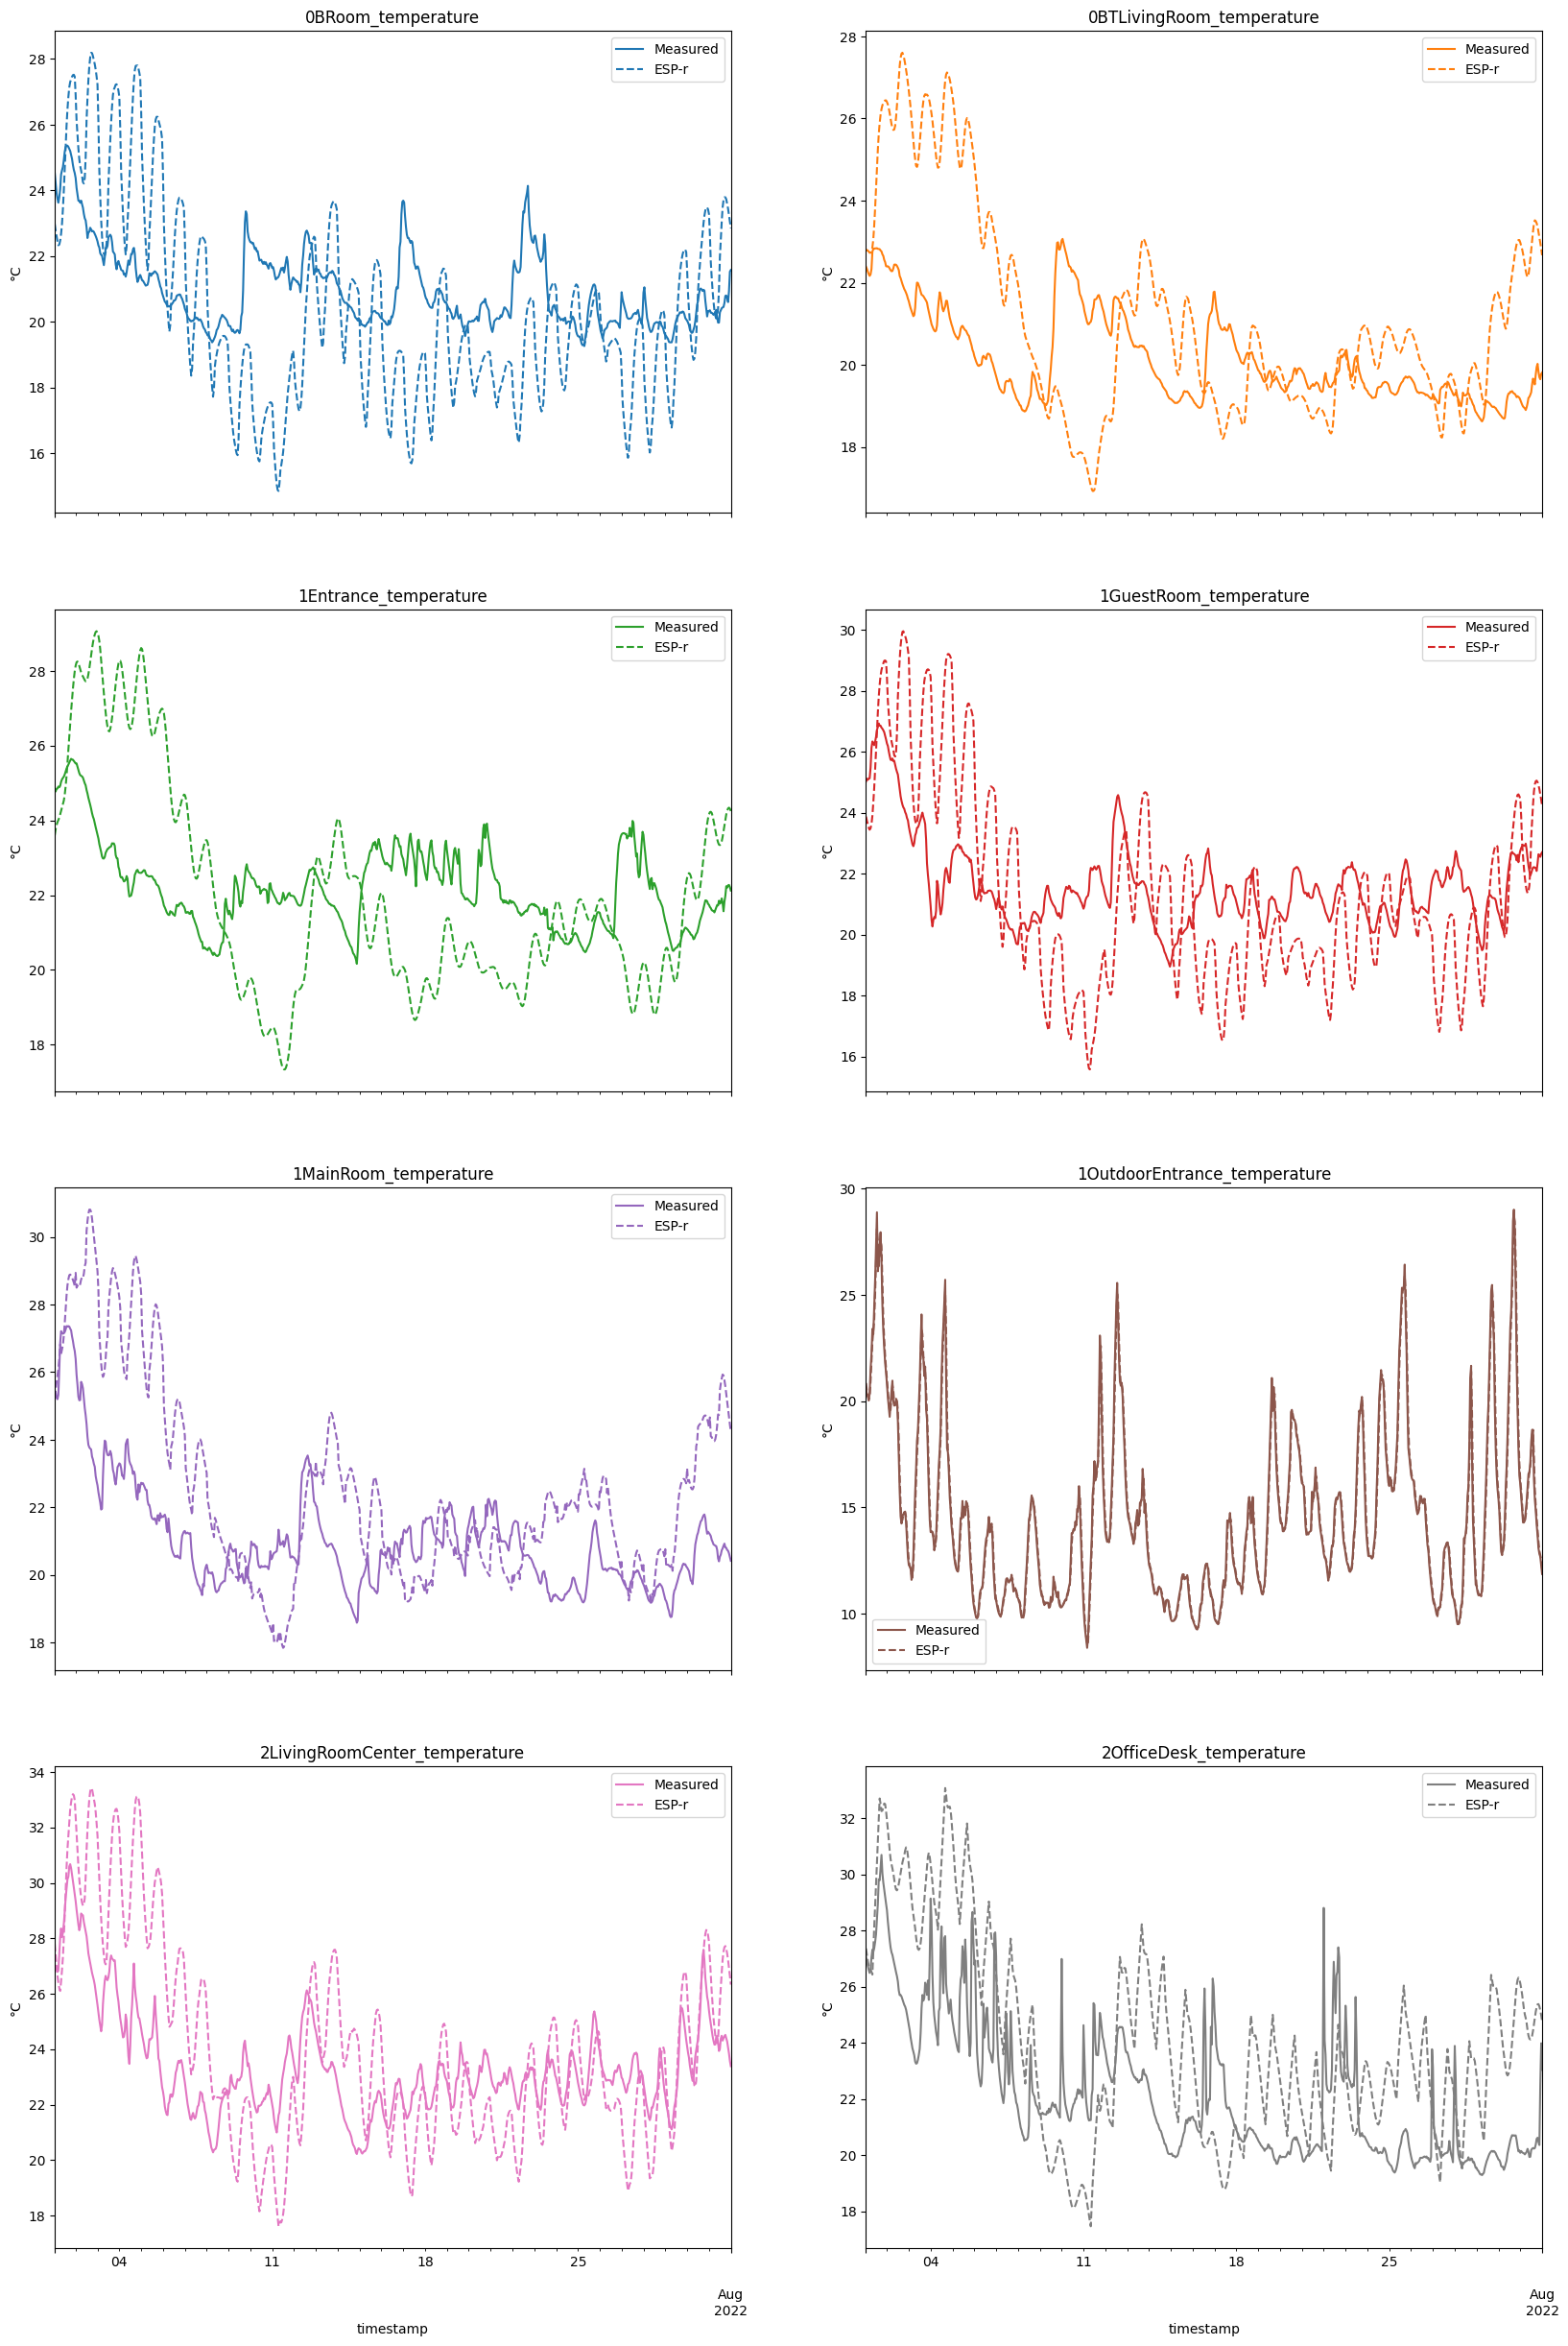

In [49]:
axs = sensor_data.plot(subplots=True, layout=(4, 2), figsize=(20, 30), title=list(sensor_data.columns), ylabel="°C")
sim_temp.plot(subplots=True, ax=axs, linestyle="dashed", legend="T")

for ax in axs:
    ax[0].legend(["Measured", "ESP-r"])
    ax[1].legend(["Measured", "ESP-r"])